## We solve the MHD toy model with PINN

### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) \;\;\;\; \nabla_i B^i = 0
$$

The vector field $v^i$ is given. 

And we impose Dirichlet boundary conditions.

The initial data is: 

\begin{align*}
B_1 &= \partial_y \phi \\
B_2 &= -\partial_x \phi
\end{align*}
with (here we use xmin=0, xmax = 1, same for y)

$$
\phi(x,y) = (x*(x-1)*y*(y-1))^2
$$

The velocity field is time-independent and given by:

\begin{align*}
v1(t,x,y) &= \sin(\pi*x)*\cos(\pi*y) \\
v2(t,x,y) &= \cos(\pi*x)*\sin(\pi*y) \\
\end{align*}



In [2]:
#import Pkg
#Pkg.add(url="https://github.com/psy3nt1st/Optim.jl.git")
using Optim
#using NeuralPDE
#using Optimization
using OptimizationOptimJL
using Roots
using LineSearches
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf
using Lux, LuxCUDA, ComponentArrays, Random
using JLD2, LinearAlgebra 
using Revise
using Distributions
using Zygote
using StatsBase
using NBInclude

const gpud = gpu_device()


┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal /Users/reula/.julia/packages/MLDataDevices/NeohJ/src/internal.jl:112


(::CPUDevice{Missing}) (generic function with 1 method)

Some parameters: 

    1. Basic 1x1x5 region: 
        a. capas internas 64x4 
        b. points 60k inner  30k initial surface, adaptive 120k 
        c. iter 500 x 20
        d. for this chain the parameter count is: 17_026

    2. JA (from 3d)
        a. capas internas 40x4 
        b. points 30k inner  ?k initial surface, adaptive ?k 
        c. iter 300-500 x 8-10

    
Parameter count formula (weights + biases):

```
total_params = N_input * N_neurons
+ N_layers * (N_neurons)^2
+ N_neurons * N_output # all weights
+ (1 + N_layers) * N_neurons # biases for the (1 + N_layers) hidden layers
+ N_output # output bias```

In [3]:
# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------

config_1 = Dict(
    :N_input => 3,          # [t , x, y]
    :N_neurons => 64,
    :N_layers => 4,
    :N_output => 2, 
    :N_points => 30_000,    # 10_000 # puntos de colisión (x,t)
    :BCS_points => 10_000,
    :N_points0 => 15_000, # 5_000 #puntos para las condiciones iniciales
    :Minibatch => 500,
    :xmin => 0.0,
    :xmax => 1.0,           # = L dominio espacial
    :ymin => 0.0,
    :ymax => 1.0,           # = L dominio espacial
    :tmin => 0.0,           # t_min
    :tmax => 5.0,      #0.4     # t_max
    #:optimizer => BFGS(),
    :optimizer => SSBroyden(),
    :maxiters => 6_000,
    :N_rounds => 20,    # 5           # nº de rondas RAD
    :iters_per_round => 500,       # iteraciones BFGS por ronda
    :k1 => 1.0, 
    :k2 => 1.0,        # hiperparámetros RAD
    :N_test => 120_000,             # candidatos por ronda, mayor que N_points
    # for the initial data
    :A => 1.0,
    :p => 4,
    :c => 1.0,
    # for discretizations
    :dx => [0.1, 0.1, 0.1], 
    #:method => :direct #:adaptive
    :method => :adaptive
)

config_2 = Dict( #this is better adjusted to have ~17k parameters
    :N_input => 3,          # [t , x, y]
    :N_neurons => 64,
    :N_layers => 4,
    :N_output => 2, 
    :N_points => 20_000,    # 10_000 # puntos de colisión (x,t)
    :BCS_points => 1_000,
    :N_points0 => 4_000, # 5_000 #puntos para las condiciones iniciales
    :Minibatch => 500,
    :xmin => 0.0,
    :xmax => 1.0,           # = L dominio espacial
    :ymin => 0.0,
    :ymax => 1.0,           # = L dominio espacial
    :tmin => 0.0,           # t_min
    :tmax => 4.0,      #0.4     # t_max
    #:optimizer => BFGS(),
    :optimizer => SSBroyden(),
    :maxiters => 6_000,
    :N_rounds => 20,    # 5           # nº de rondas RAD
    :iters_per_round => 300,       # iteraciones BFGS por ronda
    :k1 => 1.0, 
    :k2 => 1.0,        # hiperparámetros RAD
    :N_test => 40_000,             # candidatos por ronda, mayor que N_points
    # for the initial data
    :A => 1.0,
    :p => 4,
    :c => 1.0,
    # for discretizations
    :dx => [0.1, 0.1, 0.1], 
    :method => :direct #:adaptive
    #:method => :adaptive
)


config = config_2
@show config

config = Dict{Symbol, Any}(:N_input => 3, :N_test => 120000, :iters_per_round => 500, :N_points => 30000, :N_neurons => 64, :k2 => 1.0, :A => 1.0, :N_output => 2, :ymax => 1.0, :BCS_points => 10000, :ymin => 0.0, :tmax => 5.0, :maxiters => 6000, :p => 4, :c => 1.0, :N_layers => 4, :N_points0 => 15000, :method => :adaptive, :xmin => 0.0, :xmax => 1.0, :tmin => 0.0, :k1 => 1.0, :N_rounds => 20, :Minibatch => 500, :optimizer => SSBroyden{InitialStatic{Float64}, HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}(InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
  cache: Nothing nothing
  check_flatness: Bool false
, nothing, nothing, Flat()), :dx => [0.1, 0.1, 0.1])


Dict{Symbol, Any} with 26 entries:
  :N_input         => 3
  :N_test          => 120000
  :iters_per_round => 500
  :N_points        => 30000
  :N_neurons       => 64
  :k2              => 1.0
  :A               => 1.0
  :N_output        => 2
  :ymax            => 1.0
  :BCS_points      => 10000
  :ymin            => 0.0
  :tmax            => 5.0
  :maxiters        => 6000
  :p               => 4
  :c               => 1.0
  :N_layers        => 4
  :N_points0       => 15000
  :method          => :adaptive
  :xmin            => 0.0
  ⋮                => ⋮

In [4]:
includet("../neural_tools.jl")

### The velocity fields 

The actual computation for the code are done on the function compute_V_and_DV()

#### This part is just to play with different possibilities. 

In [5]:
if in_nbinclude() == false
#v1(t,x,y) = cos(pi*x)
#v2(t,x,y) = cos(pi*y) # with minus is divergence free

r20 = 0.16
r2(x,y) = (x-0.5)^2 + (y-0.5)^2
v1(t,x,y) = -2*p*(x-0.5)*r2(x,y)*(r2(x,y) - r20)
v2(t,x,y) = 2*p*(y-0.5)*r2(x,y)*(r2(x,y) - r20)
end


v2 (generic function with 1 method)

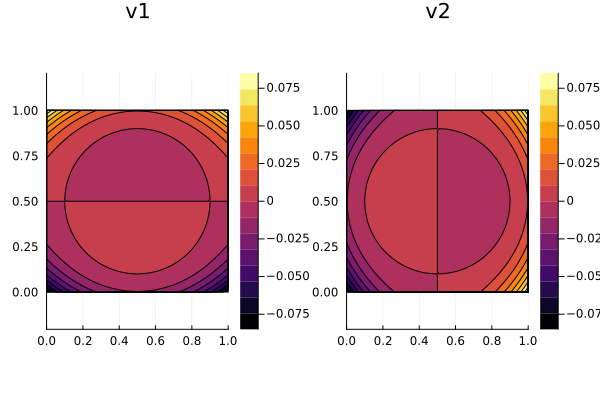

In [6]:

xs = collect(config[:xmin]:0.01:config[:xmax])
ys = collect(config[:ymin]:0.01:config[:ymax])
r0 = 0.16
if in_nbinclude() == false
v1_d = [(x-0.5)*r2(x,y)*(r2(x,y) - r0) for x in xs, y in ys]
v2_d = [(y-0.5)*r2(x,y)*(r2(x,y) - r0) for x in xs, y in ys]
pv1 = plot(ys, xs, v1_d, linetype = :contourf, title = "v1", aspect_ratio = 1)
pv2 = plot(ys, xs, v2_d, linetype = :contourf, title = "v2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))
end

### The actual function that goes in the code:

typeof(V1) = Matrix{Float64}
size(V1) = (101, 101)


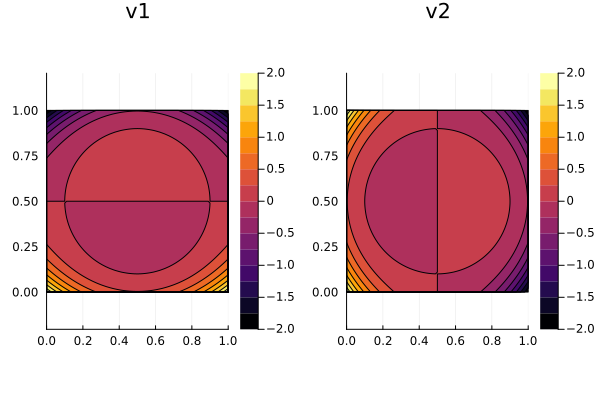

In [17]:
if in_nbinclude() == false
ts = collect(config[:tmin]:0.01:config[:tmax])
xs = collect(config[:xmin]:0.01:config[:xmax])
ys = collect(config[:ymin]:0.01:config[:ymax])

V1 = [calculate_V_and_DVs(0.0, [x,], [y,])[1][1] for x in xs, y in ys]
V2 = [calculate_V_and_DVs(0.0, [x,], [y,])[2][1] for x in xs, y in ys]

@show typeof(V1) size(V1)
#@show typeof(DxV1) size(DxV1)
#M = reshape(V1, (length(xs), length(ys)))
p1 = plot(ys, xs, V1, linetype = :contourf, title = "v1", aspect_ratio = 1)
p2 = plot(ys, xs, V2, linetype = :contourf, title = "v2", aspect_ratio = 1)
plot(p1, p2, layout = (1,2))

#@show maximum(abs.(V1))
#@show V1[1,1]
end



In [16]:
#For outgoing boundary conditions 
@show minimum(V1[1,:]) # has to be positive
@show maximum(V1[end,:]) # has to be negative
@show minimum(V2[:,1]) # has to be positive
@show maximum(V2[:,end,:]) # has to be negative

minimum(V1[1, :]) = 0.2647058823529412
maximum(V1[end, :]) = -0.2647058823529412
minimum(V2[:, 1]) = 0.2647058823529412
maximum(V2[:, end, :]) = -0.2647058823529412


-0.2647058823529412

### The initial magnetic fields

The actual computations are done on the function for the boundary (initial) conditions.

In [ ]:
#=
phi(x,y) = (x*(x-1)*y*(y-1))^4*2^(4p)

p= config[:p]
B1_d = [ p*y^(p-1)*(y-1)^(p-1)*(2y-1)*x^p*(x-1)^p*2^(4p) for x in xs for y in ys]
B2_d = [ -p*x^(p-1)*(x-1)^(p-1)*(2x-1)*y^p*(y-1)^p*2^(4p) for x in xs for y in ys]
pv1 = plot(xs, ys, B1_d, linetype = :contourf, title = "Initial B1", aspect_ratio = 1)
pv2 = plot(xs, ys, B2_d, linetype = :contourf, title = "Initial B2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))
=#



The actual function that goes into the code

In [ ]:

function B0(x,y,p)
    B1_0 =  p.*y.^(p-1).*(y.-1).^(p-1).*(2y.-1).*x.^p.*(x.-1).^p.*2^(4p)
    B2_0 = -p.*x.^(p-1).*(x.-1).^(p-1).*(2x.-1).*y.^p.*(y.-1).^p.*2^(4p)
    return B1_0, B2_0 
end

In [ ]:

if in_nbinclude() == false
ts = collect(config[:tmin]:0.01:config[:tmax])
xs = collect(config[:xmin]:0.01:config[:xmax])
ys = collect(config[:ymin]:0.01:config[:ymax])

xl = repeat(xs, inner=length(ys))
yl = repeat(ys, outer=length(xs))
tl = zeros(length(xs)*length(ys));



#B1 = [B0([x,], [y,], 4)[1][1] for x in xs, y in ys]
#B2 = [B0([x,], [y,], 4)[2][1] for x in xs, y in ys]

B1l = B0(xl, yl, 4)[1] #this way it is a x and y are long vectors undoing the square into a line.
B2l = B0(xl, yl, 4)[2] 

@show typeof(vec(B1l)) size(vec(B1l))
#@show typeof(DxV1) size(DxV1)
#M = reshape(V1, (length(xs), length(ys)))
p1 = plot(ys, xs, B1l, linetype = :contourf, title = "B1", aspect_ratio = 1) # this plot makes an automatinc reshaping
p2 = plot(ys, xs, B2l, linetype = :contourf, title = "B2", aspect_ratio = 1)
plot(p1, p2, layout = (1,2))
end


### The equations

In [ ]:

eqs(B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2, V1, V2, DxV1, DxV2, DyV1, DyV2) = [DtB1 - DyV2 .* B1 - V2 .* DyB1 + DyV1 .* B2 + DyB2 .* V1, 
    DtB2 - DxV1 .* B2 - V1 .* DxB2 + DxV2 .* B1 + DxB1 .* V2 , 
    DxB1 + DyB2]


### Boundary conditions

Using the constraint the equations are equivalent to:

$$
\partial_t B^i = v^j\partial_j B^i + l.o.t.
$$
Thus, at the boundaries we have to impose boundary conditions (non-incoming in our case) only when
$v^jn_j \geq 0$.

Otherwise we could put periodic boundary conditions by imposing for instance $B^i(t,0,y) = B^i(t,L,y)$


In [ ]:
non_incoming = false
periodic = false

#non_incoming = true
#periodic = true
if non_incoming 
bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20,
    (1 - sign(V1[0,:]))*sign(V1[0,:])*B1[0,:],
    (1 + sign(V1[end,:]))*sign(V1[end,:])*B1[end,:],
    (1 - sign(V2[:,0]))*sign(V2[:,0])*B1[:,0],
    (1 + sign(V2[:,end]))*sign(V2[:,end])*B1[:,end],
    (1 - sign(V1[0,:]))*sign(V1[0,:])*B2[0,:],
    (1 + sign(V1[end,:]))*sign(V1[end,:])*B2[end,:],
    (1 - sign(V2[:,0]))*sign(V2[:,0])*B2[:,0],
    (1 + sign(V2[:,end]))*sign(V2[:,end])*B2[:,end]]

elseif periodic

    bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20] # periodicity is hard implemented
    
else
    bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20] # when V is outgoing in all the boundary.
end


In [ ]:
NN, Θ, st = create_neural_network(config)

In [ ]:

input = generate_input_t_x_y(config) # the order is t,x,y.
input0 = generate_input0_xy(config) # the order is t,x,y.
input_total = [input, input0]

@show typeof(input) size(input)
@show typeof(input_total) size(input_total)
@show typeof(Θ) size(Θ)
@show typeof(NN(input[:,:], Θ, st)[1]) size(NN(input[:,:], Θ, st)[1])

#NN(input[:,:], Θ, st)[1][1,:]

In [ ]:
# input0[1:1,:,:]

In [ ]:
#input_total[2][3:3,:] # the inputs are working OK


In [ ]:
#=
t, x, y = input_total[1][1:1, :], input_total[1][2:2, :], input_total[1][3:3, :]

B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2 = calculate_fields_and_derivatives_Toy_MHD(t, x, y, NN, Θ, st)

@show typeof(B1) size(B1)
@show typeof(DtB1) size(DtB1)
#y
B1
=#

In [ ]:
```
Residual at collocation points
``` 

function residual_at_points_Toy_MHD(input_total, NN, Θ, st)
    # residual for the equations
    t, x, y = input_total[1][1:1, :], input_total[1][2:2, :], input_total[1][3:3, :]
    B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2  = calculate_fields_and_derivatives_Toy_MHD(t, x, y, NN, Θ, st)
    V1, V2, DxV1, DxV2, DyV1, DyV2 = calculate_V_and_DVs(t, x, y)
    #println("V1: ", V1)
    res_eq = eqs(B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2, V1, V2, DxV1, DxV2, DyV1, DyV2)
    # residual for the initial conditions
    t0, x0, y0 = input_total[2][1:1, :], input_total[2][2:2, :], input_total[2][3:3, :]
    B10, B20 = B0(x0, y0, config[:p])
    #@show typeof(B10) size(B10)
    B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2  = calculate_fields_and_derivatives_Toy_MHD(t0, x0, y0, NN, Θ, st)
    #@show typeof(B1) size(B1)
    V1, V2, DxV1, DxV2, DyV1, DyV2 = calculate_V_and_DVs(t0, x0, y0)
    res_bc = bcs(B1, B2, vec(B10), vec(B20), V1, V2)
    #res = vcat(res_eq, res_bc)
    #@show typeof(vec(res_eq[1] |> cpu_device())) size(vec(res_eq[1] |> cpu_device()))
    return vcat(vec(abs.(res_eq[1] |> cpu_device())), vec(abs.(res_eq[2] |> cpu_device())), vec(abs.(res_eq[3] |> cpu_device()))),  vcat(vec(abs.(res_bc[1] |> cpu_device())), vec(abs.(res_bc[2] |> cpu_device()))) # magnitud del residuo en CPU
end


In [ ]:
#residual_at_points_Toy_MHD(input_total, NN, Θ, st)

In [ ]:
#Eq, BC = residual_at_points_Toy_MHD(input_total, NN, Θ, st)

In [ ]:

# -------------------------------------------------------------------
# Loss function 
# -------------------------------------------------------------------

function loss_function_Toy_MHD(input_total, NN, Θ, st)
    res_eq, res_bcs = residual_at_points_Toy_MHD(input_total, NN, Θ, st)
    #return NaNMath.log10(sum(abs2, res) / length(res))
    loss_eq = sum(abs2, res_eq) / length(res_eq)
    loss_bcs = sum(abs2, res_bcs) / length(res_bcs)
    #println("Loss eq: ", loss_eq, " Loss bcs: ", loss_bcs)
    return log10(loss_eq + loss_bcs)
    #return sum(abs2, res_eq) / length(res_eq) + sum(abs2, res_bcs) / length(res_bcs)
end


# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

In [ ]:
#loss_function_Toy_MHD(input, NN, Θ, st)
losses = Float64[]

In [ ]:
#adaptive = true
#adaptive = false

@unpack N_rounds, iters_per_round, N_test, N_points, method = config
#optf   = OptimizationFunction((Θ, input_total) -> loss_function_Toy_MHD(input_total, NN, Θ, st), AutoZygote())

if method === :adaptive 
    
    # Configura las rondas adaptativas (ajusta a tu gusto)
    #nrounds = 20                # nº de rondas RAD
    #iters_per_round = 500       # iteraciones BFGS por ronda
    #k1, k2 = 1.0, 1          # hiperparámetros RAD
    #Ntest = 20_000              # candidatos por ronda

    for r in 1:N_rounds
        @info "RAD round $r / $N_rounds  |  iters=$iters_per_round"
        # Optimiza sobre el conjunto actual de colisión
        global optf   = OptimizationFunction((Θ, input) -> loss_function_Toy_MHD(input, NN, Θ, st), AutoZygote())
        global optprob = OptimizationProblem(optf, Θ, input_total)
        global optresult  = solve(
            optprob,
            config[:optimizer];
            callback = (p, l) -> callback(p, l, losses),
            maxiters = iters_per_round,
        )
        global Θ = optresult.u  # continúa desde el óptimo de la ronda

        # Re-muestrea puntos de colisión ponderando por residuo
        global input = adaptive_rad_toy_MHD(NN, Θ, st, config; Ntest=N_test, Nint=N_points)#, k1=k1, k2=k2)
        global input0 = generate_input0_xy(config) # reset input0
        global input_total = [input, input0]
    end

else
    for r in 1:N_rounds
        
        @info "Normal training round $r / $N_rounds  |  iters=$iters_per_round"

        global optf = OptimizationFunction((Θ, input) -> loss_function_Toy_MHD(input, NN, Θ, st), AutoZygote())
        global optprob = OptimizationProblem(optf, Θ, input_total)

        global optresult = solve(
            optprob,
            callback = (p, l) -> callback(p, l, losses),
            config[:optimizer],
            maxiters = iters_per_round,
        )
        global Θ = optresult.u  # continúa desde el óptimo de la ronda

        # Nueva muestra de puntos de colisión.

        global input = generate_input_t_x_y(config) # reset input
        global input0 = generate_input0_xy(config) # reset input0
        global input_total = [input, input0]
        
    end
end

# Parámetros optimizados a CPU si procede
res = Θ |> cpu_device()


In [ ]:
#res = Θ |> cpu_device()

In [ ]:
#Y, _ = residual_at_points_Toy_MHD(input_total, NN, Θ, st)

In [ ]:
#adaptive_rad_toy_MHD(NN, Θ, st, config; Ntest=N_test, Nint=N_points)#, k1=k1, k2=k2)

In [ ]:
println("Training completed. Saving data")
if method == :direct
    @save "toy_MHD_2D_Man_comp.jld2" config res st losses
elseif method == :adaptive
    @save "toy_MHD_2D_Man_Ada.jld2" config res st losses 
else
    @save "toy_MHD_2D_Man_try.jld2" config res st losses
end


In [ ]:
if in_nbinclude()
    exit()
end

In [ ]:
plot(losses, title = "Loss history", xlabel = "Iteration", ylabel = "Loss",
    #yscale = :log10
    )


In [ ]:
#Θ = optresult.u |> cpu_device()
#res = optresult.u |> cpu_device()

In [ ]:

@unpack tmin, tmax, xmin, xmax, ymin, ymax = config
xs = collect(xmin:0.01:xmax)
ys = collect(ymin:0.01:ymax);

t = 0.0
B1_approx = [NN(vcat(t, x, y), res, st)[1][1] for x in xs, y in ys]
B2_approx = [NN(vcat(t, x, y), res, st)[1][2] for x in xs, y in ys]
plt1 = plot(ys, xs, B1_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B1", aspect_ratio = 1)
plt2 = plot(ys, xs, B2_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B2", aspect_ratio = 1)
#ps = [p1, p2]
#plot(plt,ps..., layout = (1,2), size = (900,400))


#plot(plt1,plt2, layout = (1,2), size = (900,400))
plt1

In [ ]:
@unpack tmin, tmax, xmin, xmax, ymin, ymax = config
xs = collect(xmin:0.01:xmax)
ys = collect(ymin:0.01:ymax);

t = 0.0
B1_approx = [NN(vcat(t, x, y), res, st)[1][1] for x in xs, y in ys]
B2_approx = [NN(vcat(t, x, y), res, st)[1][2] for x in xs, y in ys]
plt1 = plot(ys, xs, B1_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B1", aspect_ratio = 1)
plt2 = plot(ys, xs, B2_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B2", aspect_ratio = 1)
ps = [plt1, plt2]
plot(ps..., layout = (1,2), size = (900,400))

In [ ]:
plot(ys, xs, B1_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B1", aspect_ratio = 1)